## Simple Kalman estimator (no control)

Sawyer B. Fuller, 2020.01.12

Boilerplate imports

In [1]:
import numpy as np
from numpy import array as arr
import matplotlib.pyplot as plt
import control
from random import gauss # random number generator with a normal distribution. arguments: mean, stddev

Dynamics system is a damped body moving through space: m * vdot  = -b * v + u 

In [2]:

m = 1
b = 1
sensor_noise_std = .1

def simulate_dynamics(q, u=0):
    v = q
    return -b/m * v + u/m

def simulate_sensor_readings(q):
    v = q
    return v + gauss(0, sensor_noise_std)

A = arr(-b/m, ndmin=2)
B = arr(1/m, ndmin=2)
G = arr(1, ndmin=2)
C = arr(1, ndmin=2)

Check observability

In [3]:
obsv = control.obsv(A, C) 
print(np.linalg.det(obsv)) # gives nonzero answer => full rank => is observable

1.0


## A) 
construct weight matrices and kalman gain matrix for QN = 0.1

In [9]:
def lqe(A, G, C, QN, RN):
    # function to calculate Kalman gain (only recently contributed to python-control)
    QN = arr(QN, ndmin=2) 
    P, E, K = control.care(A.T, C.T, G @ QN @ G.T, RN)
    return K.T, P, E 

# disturbance size
QN = .1 # tuning knob
RN = sensor_noise_std**2
L = lqe(A, G, C, QN, RN)[0]
print(L)

[[2.31662479]]


Simulate

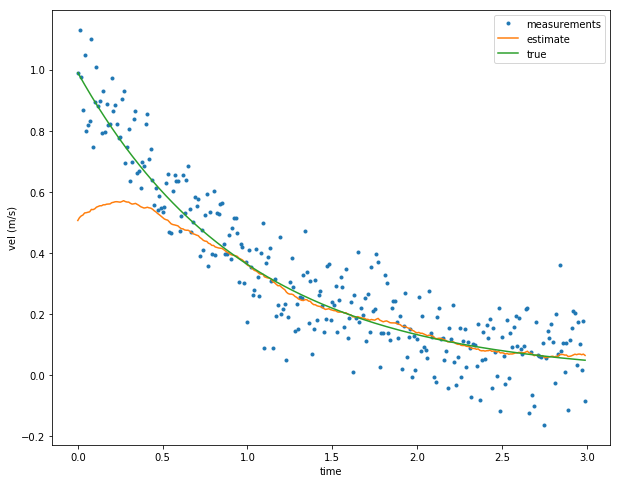

In [10]:
dt = 0.01
time = np.arange(0, 3, dt)
q = arr((1,)) # initial condition
qhat = arr((.5,)) # initial estimate

q_data = np.zeros((len(time), len(q))) # log of state vector
y_data = np.zeros((len(time), 1))
qhat_data = np.zeros((len(time), len(q)))

for idx, t in enumerate(time):
    y = simulate_sensor_readings(q)
    q = q + dt * simulate_dynamics(q)
    qhatdot = A @ qhat + L @ (y - C @ qhat)
    qhat = qhat + dt * qhatdot
    q_data[idx,:] = q
    qhat_data[idx,:] = qhat
    y_data[idx,:] = y 

plt.figure(figsize=(10,8))
plt.plot(time, y_data, '.', time, qhat_data, time, q_data)
plt.xlabel('time'); plt.ylabel('vel (m/s)')
plt.legend(('measurements', 'estimate', 'true'))

## B) 
now try with greater disturbance noise => greater L => depend more on sensor readings

[[9.04987562]]


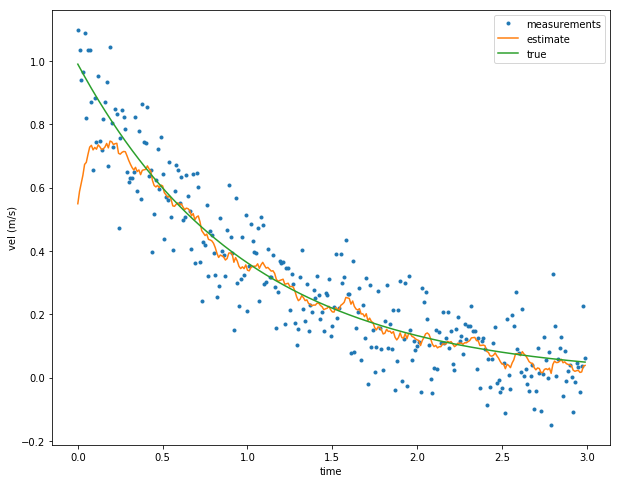

In [11]:
# disturbance size
QN = 1 # tuning knob
L = lqe(A, G, C, QN, RN)[0]
print(L)

q = arr((1,)) # initial condition
qhat = arr((.5,)) # initial estimate
for idx, t in enumerate(time):
    y = simulate_sensor_readings(q)
    q = q + dt * simulate_dynamics(q)
    qhatdot = A @ qhat + L @ (y - C @ qhat)
    qhat = qhat + dt * qhatdot
    q_data[idx,:] = q
    qhat_data[idx,:] = qhat
    y_data[idx,:] = y 
    
plt.figure(figsize=(10,8))
plt.plot(time, y_data, '.', time, qhat_data, time, q_data)
plt.xlabel('time'); plt.ylabel('vel (m/s)')
plt.legend(('measurements', 'estimate', 'true'))

Without a dynamics model, the Kalman Filter behaves something like a simple low-pass filter. Downside: significant lag. 

[[2.31662479]]


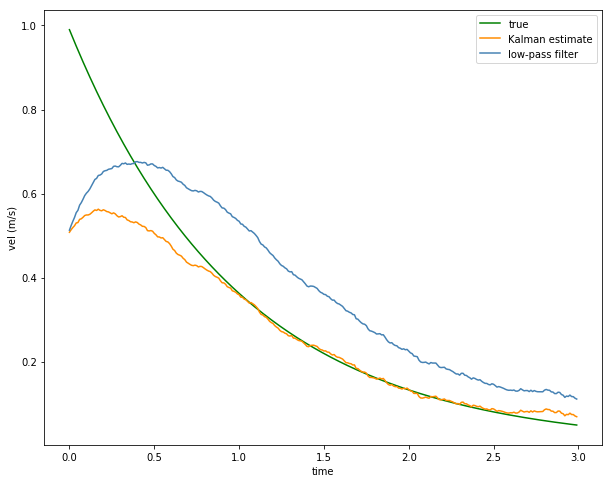

In [12]:
QN = .1 # tuning knob: decrease this => rely more on prediction than sensors
L = lqe(A, G, C, QN, RN)[0]
print(L)
q = arr((1,)) # initial condition
qhat = arr((.5,)) # initial estimate
q_lopass = arr((.5,))
q_lopass_data = np.zeros((len(time),1))
for idx, t in enumerate(time):
    y = simulate_sensor_readings(q)
    q = q + dt * simulate_dynamics(q)
    qhatdot = A @ qhat + L @ (y - C @ qhat)
    qhat = qhat + dt * qhatdot
    q_lopass = q_lopass + dt * L @ (y - C @ q_lopass)
    q_data[idx,:] = q
    qhat_data[idx,:] = qhat
    q_lopass_data[idx,:] = q_lopass
    y_data[idx,:] = y 
    
plt.figure(figsize=(10,8))
plt.plot(time, q_data, 'green', time, qhat_data, 'darkorange', time, q_lopass_data, 'steelblue')
plt.xlabel('time'); plt.ylabel('vel (m/s)')
plt.legend(('true', 'Kalman estimate', 'low-pass filter'))

## C) 
velocity sensing with optic flow

[[8.61187421]]


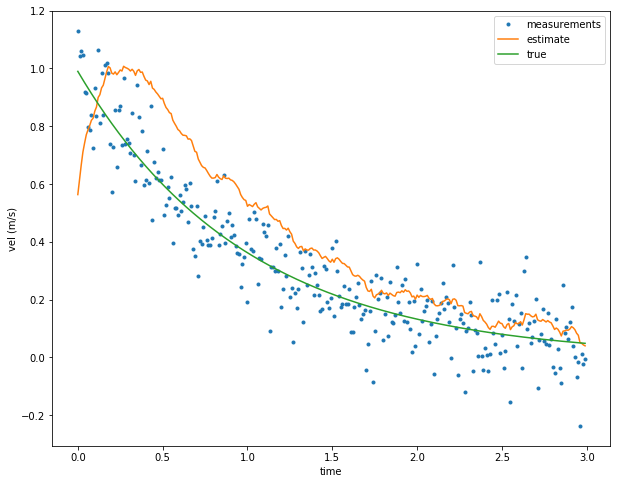

In [14]:
# disturbance size
QN = 1 # tuning knob
# new C linearized at z = z_d
z_d = 1.5
C = arr(1/z_d, ndmin=2)
L = lqe(A, G, C, QN, RN)[0]
print(L)

q = arr((1,)) # initial condition
qhat = arr((.5,)) # initial estimate
for idx, t in enumerate(time):
    y = simulate_sensor_readings(q)
    q = q + dt * simulate_dynamics(q)
    qhatdot = A @ qhat + L @ (y - C @ qhat)
    qhat = qhat + dt * qhatdot
    q_data[idx,:] = q
    qhat_data[idx,:] = qhat
    y_data[idx,:] = y 
    
plt.figure(figsize=(10,8))
plt.plot(time, y_data, '.', time, qhat_data, time, q_data)
plt.xlabel('time'); plt.ylabel('vel (m/s)')
plt.legend(('measurements', 'estimate', 'true'))